# Classification - Austin animal shelter

## This project utilizes the entire data science process in order to predict shelter outcomes.

### It includes data cleaning, transforming, model testing, and statistical valuation of predictions. All code, transformation, and methods are original work unless otherwise noted.

#### Source: https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-outcomes-and

#### Website description and overview:

### Context
The Austin Animal Center is the largest no-kill animal shelter in the United States that provides care and shelter to over 18,000 animals each year and is involved in a range of county, city, and state-wide initiatives for the protection and care of abandoned, at-risk, and surrendered animals.

As part of the City of Austin Open Data Initiative, the Austin Animal Center makes available its collected dataset that contains statistics and outcomes of animals entering the Austin Animal Services system.

### Content
The dataset contains shelter outcomes of several types of animals and breeds from 10/1/2013 to the present with a hourly time frequency. The data is updated daily.

The Austin Animal Center's original dataset includes columns for name, date of birth, outcome, animal type, sex and age at time of outcome, breed, and color. Outcomes range widely and include things like adoptions and transfers to other shelters.

In [1]:
# Imports!
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

In [2]:
# Reading in the data set.
df = pd.read_csv('../../_Datasets/aac_shelter_outcomes.csv')
df2 = df.copy()
df.head(3)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,outcome_type,sex_upon_outcome
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Transfer,Intact Male
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Transfer,Spayed Female
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Adoption,Neutered Male


In [3]:
# Nulls aren't too bad, except for name and outcome_subtype. (I did not originally see the two on outcome_type.)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78256 entries, 0 to 78255
Data columns (total 12 columns):
age_upon_outcome    78248 non-null object
animal_id           78256 non-null object
animal_type         78256 non-null object
breed               78256 non-null object
color               78256 non-null object
date_of_birth       78256 non-null object
datetime            78256 non-null object
monthyear           78256 non-null object
name                54370 non-null object
outcome_subtype     35963 non-null object
outcome_type        78244 non-null object
sex_upon_outcome    78254 non-null object
dtypes: object(12)
memory usage: 7.2+ MB


# Feature ideas

### After a quick look, we already see some features in need of 'fixing'

1. Adopted or not
    - Create binaries from the adopted feature. We can consider adopted or not and use get_dummies.
2. Drop monthyear, it is the same as 'datetime'
    - We don't need identical features - drop one of them.
3. Animal has name or has no name
    - This might be useful. Do parents think about temperament correlation with having a name or not?
4. Animal types dummies
    - We can run get_dummies on types of animals. We will probably use cats, dogs, and others.
5. Spayed/neutered vs others
    - Potential adopting parents are likely to weigh fixed animals versus those that aren't.
6. Convert age to common measurement
    - Ages value are all over the place - also has NaN values.
7. Simplify colors with regex, etc.
    - Colors might have correlation with adoption rates, we can find a way to include these values.
8. Feature creation on breed
    - Maybe we can pull some features out of the breeds.

In [4]:
# 1. We want to create a binary outcome for y.
df.outcome_type.value_counts()

Adoption           33112
Transfer           23499
Return to Owner    14354
Euthanasia          6080
Died                 680
Disposal             307
Rto-Adopt            150
Missing               46
Relocate              16
Name: outcome_type, dtype: int64

In [5]:
# Creating the variable with adoption versus the rest.
df.dropna(subset=['outcome_type'], inplace=True)
df['binary_outcome_adopted'] = (df.outcome_type == 'Adoption') * 1
df.drop('outcome_type', 1, inplace=True)
df.head(3)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,datetime,monthyear,name,outcome_subtype,sex_upon_outcome,binary_outcome_adopted
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,2014-07-22T16:04:00,NaN,Partner,Intact Male,0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,2013-11-07T11:47:00,Lucy,Partner,Spayed Female,0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,2014-06-03T14:20:00,*Johnny,NaN,Neutered Male,1


In [6]:
# 2. Equivalent columns.
# This code confirms these two columns are identical.
(df.datetime == df.monthyear).value_counts()

True    78244
dtype: int64

In [7]:
# Remove monthyear and rename.
df.drop('monthyear', 1, inplace=True)
df.rename(columns={'datetime': 'exit_datetime'}, inplace=True)
df.head()

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,exit_datetime,name,outcome_subtype,sex_upon_outcome,binary_outcome_adopted
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,NaN,Partner,Intact Male,0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Lucy,Partner,Spayed Female,0
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,*Johnny,NaN,Neutered Male,1
3,9 years,A680386,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,Monday,Partner,Neutered Male,0
4,5 months,A683115,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,NaN,Rabies Risk,Unknown,0


In [8]:
# 3. Binary given_name feature.
df.name.notna().value_counts()

True     54363
False    23881
Name: name, dtype: int64

In [9]:
# Name feature looks useful. Created below.
df['has_name_binary'] = df.name.notna() * 1
df.drop('name', 1, inplace=True)
df.head(3)

,age_upon_outcome,animal_id,animal_type,breed,color,date_of_birth,exit_datetime,outcome_subtype,sex_upon_outcome,binary_outcome_adopted,has_name_binary
0,2 weeks,A684346,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,Partner,Intact Male,0,0
1,1 year,A666430,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Partner,Spayed Female,0,1
2,1 year,A675708,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,NaN,Neutered Male,1,1


In [10]:
# 4. We may be able to use animal type in our model.
df.animal_type.value_counts()

Dog          44238
Cat          29419
Other         4244
Bird           334
Livestock        9
Name: animal_type, dtype: int64

In [11]:
# Using dummies for dog, cat, and placing the rest in the 'other' bin.
df['animal_dog'] = (df.animal_type == 'Dog') * 1
df['animal_cat'] = (df.animal_type == 'Cat') * 1
df['animal_other'] = ((df.animal_type == 'Other') | (df.animal_type == 'Bird') | (df.animal_type == 'Livestock')) * 1
df.drop('animal_type', 1, inplace=True)
df.head(3)

,age_upon_outcome,animal_id,breed,color,date_of_birth,exit_datetime,outcome_subtype,sex_upon_outcome,binary_outcome_adopted,has_name_binary,animal_dog,animal_cat,animal_other
0,2 weeks,A684346,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,Partner,Intact Male,0,0,0,1,0
1,1 year,A666430,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Partner,Spayed Female,0,1,1,0,0
2,1 year,A675708,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,NaN,Neutered Male,1,1,1,0,0


In [12]:
# 5. Spayed or neutered feature. What's the distribution?
df.sex_upon_outcome.value_counts()

Neutered Male    27783
Spayed Female    25203
Intact Male       9547
Intact Female     9140
Unknown           6570
Name: sex_upon_outcome, dtype: int64

In [13]:
# Creating variables for fixed, male, and female animals
# Only equal values for the male/female column is at - |unknown|
fixed = df.sex_upon_outcome.str.contains(r'\bNeutered\b|\bSpayed\b', regex=True)
male = df.sex_upon_outcome.str.contains(r'\bMale\b', regex=True)
female = df.sex_upon_outcome.str.contains(r'\bFemale\b', regex=True)

df[female == male]['sex_upon_outcome'].value_counts()

Unknown    6570
Name: sex_upon_outcome, dtype: int64

In [14]:
# Generating gender and fixed features from variables.
df['gender_binary'] = female * 1
df['fixed_binary'] = fixed * 1
df.drop('sex_upon_outcome', 1, inplace=True)
df.head(3)

,age_upon_outcome,animal_id,breed,color,date_of_birth,exit_datetime,outcome_subtype,binary_outcome_adopted,has_name_binary,animal_dog,animal_cat,animal_other,gender_binary,fixed_binary
0,2 weeks,A684346,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,Partner,0,0,0,1,0,0,0
1,1 year,A666430,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Partner,0,1,1,0,0,1,1
2,1 year,A675708,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,NaN,1,1,1,0,0,0,1


In [15]:
# 6. Thoughts: age_upon_outcome is looking pretty ugly, how inconsistent is this feature?
# If we check birthday against departure, are the numbers good?
for val in np.random.randint(0, len(df), 8):
    print(df.age_upon_outcome.loc[val])
    print(pd.to_datetime(df.exit_datetime.loc[val]) - pd.to_datetime(df.date_of_birth.loc[val]), '\n')

6 years
2216 days 17:33:00 

2 months
86 days 17:05:00 

3 years
1101 days 12:56:00 

1 year
410 days 15:43:00 

3 months
111 days 14:25:00 

4 months
124 days 16:58:00 

2 months
80 days 17:02:00 

1 month
57 days 12:51:00 



In [16]:
# df.info() above also states it has NaN values.
df[df.age_upon_outcome.isna()]

,age_upon_outcome,animal_id,breed,color,date_of_birth,exit_datetime,outcome_subtype,binary_outcome_adopted,has_name_binary,animal_dog,animal_cat,animal_other,gender_binary,fixed_binary
77976,NaN,A765547,Leghorn Mix,White/Red,2017-01-22T00:00:00,2018-01-25T13:23:00,Partner,0,0,0,0,1,1,0
78081,NaN,A765899,Miniature Poodle Mix,Black,2011-01-29T00:00:00,2018-01-29T15:49:00,Suffering,0,0,1,0,0,0,1
78114,NaN,A765914,Domestic Shorthair Mix,Lynx Point,2017-01-29T00:00:00,2018-01-29T18:08:00,Suffering,0,0,0,1,0,0,0
78162,NaN,A765901,Maltese Mix,Buff,2017-01-29T00:00:00,2018-01-31T08:14:00,Partner,0,0,1,0,0,0,0
78208,NaN,A765960,Beagle/Catahoula,Tan/White,2010-02-01T00:00:00,2018-02-01T09:21:00,Suffering,0,0,1,0,0,0,0
78253,NaN,A766098,Bat Mix,Brown,2017-02-01T00:00:00,2018-02-01T18:08:00,Rabies Risk,0,0,0,0,1,0,0


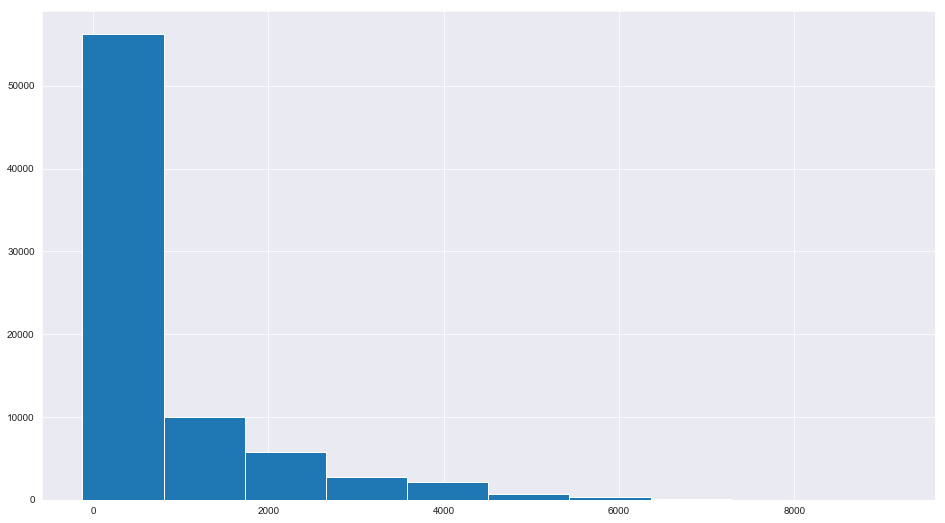

In [17]:
# This trick seems to make a usable datetime (timedelta) object.
(pd.to_datetime(df.exit_datetime) - pd.to_datetime(df.date_of_birth)).dt.days.hist(figsize=(16, 9))

In [18]:
# Let's use it. 
# This converts relevant datetime entries into datetime format and creates a timedelta for age_upon_outcome.
df['age_upon_outcome'] = pd.to_datetime(df.exit_datetime) - pd.to_datetime(df.date_of_birth)
df['date_of_birth'] = pd.to_datetime(df.date_of_birth)
df['exit_datetime'] = pd.to_datetime(df.exit_datetime)
df.head(3)

,age_upon_outcome,animal_id,breed,color,date_of_birth,exit_datetime,outcome_subtype,binary_outcome_adopted,has_name_binary,animal_dog,animal_cat,animal_other,gender_binary,fixed_binary
0,15 days 16:04:00,A684346,Domestic Shorthair Mix,Orange Tabby,2014-07-07,2014-07-22 16:04:00,Partner,0,0,0,1,0,0,0
1,366 days 11:47:00,A666430,Beagle Mix,White/Brown,2012-11-06,2013-11-07 11:47:00,Partner,0,1,1,0,0,1,1
2,429 days 14:20:00,A675708,Pit Bull,Blue/White,2013-03-31,2014-06-03 14:20:00,NaN,1,1,1,0,0,0,1


In [19]:
# 7. Colors?
len(df.color.value_counts())

525

In [20]:
# This will give us an idea of how much orange, black, brown, and other common colors account for the animals' colors.
display(df.color.str.contains(r'\borange\b|\bblack\b|\bblue\b|\bbrown\b|\bwhite\b|\btan\b|\bcalico\b|\bred\b', 
                      regex=True, case=False).value_counts())

df[df.color.str.contains(r'\borange\b|\bblack\b|\bblue\b|\bbrown\b|\bwhite\b|\btan\b|\bcalico\b|\bred\b', 
                      regex=True, case=False) == False]['color'].value_counts()[:5]

True     68828
False     9416
Name: color, dtype: int64

Tricolor       1982
Tortie         1340
Torbie          845
Yellow          510
Cream Tabby     498
Name: color, dtype: int64

In [21]:
# We can add a few more to the list - tricolor, gray, yellow, and the tortie/torbie - and see how much more is covered.
df[df.color.str.contains(r'\borange\b|\bblack\b|\bblue\b|\bbrown\b|\bwhite\b|\btan\b|\bcalico\b|\bred\b|\btricolor\b|\bgray\b|\byellow\b|\btabby\b|\btortie\b|\btorbie\b',
                         regex=True, case=False) == False]['color'].value_counts()[:5]

Sable         476
Lynx Point    439
Cream         435
Chocolate     413
Buff          386
Name: color, dtype: int64

In [22]:
# That color list looks solid - the regex tricks will allow us to convert things like Brown/Red into brown 1 and red 1,
# making sure we account for common colors even if there are multiple.
color_list = ['orange', 'black', 'blue', 'brown', 'white', 'tan', 'calico', 'red', 'tricolor', 'gray', 'yellow', 'tabby', 'tortie', 'torbie']
for color in color_list:
    df['color_' + str(color)] = df.color.str.contains(r'\b' + color, case=False) * 1

df['color_tortie_torbie'] = df.color_torbie * 1 + df.color_tortie * 1

# Creating color feature for 'others' - we might want this (Spoiler alert...we will)
color_others = df[df.color.str.contains(r'\borange\b|\bblack\b|\bblue\b|\bbrown\b|\bwhite\b|\btan\b|\bcalico\b|\bred\b|\btricolor\b|\bgray\b|\byellow\b|\btabby\b|\btortie\b|\btorbie\b',
                         regex=True, case=False) == False]['color']
df.drop(['color', 'color_tortie', 'color_torbie'], 1, inplace=True)
df.head(3)

,age_upon_outcome,animal_id,breed,date_of_birth,exit_datetime,outcome_subtype,binary_outcome_adopted,has_name_binary,animal_dog,animal_cat,...,color_brown,color_white,color_tan,color_calico,color_red,color_tricolor,color_gray,color_yellow,color_tabby,color_tortie_torbie
0,15 days 16:04:00,A684346,Domestic Shorthair Mix,2014-07-07,2014-07-22 16:04:00,Partner,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,366 days 11:47:00,A666430,Beagle Mix,2012-11-06,2013-11-07 11:47:00,Partner,0,1,1,0,...,1,1,0,0,0,0,0,0,0,0
2,429 days 14:20:00,A675708,Pit Bull,2013-03-31,2014-06-03 14:20:00,NaN,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0


In [23]:
# 8. What are some trends in breed?
df.breed.value_counts()[:15]

Domestic Shorthair Mix       23332
Pit Bull Mix                  6133
Chihuahua Shorthair Mix       4733
Labrador Retriever Mix        4607
Domestic Medium Hair Mix      2323
German Shepherd Mix           1892
Bat Mix                       1283
Domestic Longhair Mix         1228
Australian Cattle Dog Mix     1059
Siamese Mix                    998
Bat                            799
Dachshund Mix                  798
Boxer Mix                      674
Miniature Poodle Mix           648
Border Collie Mix              646
Name: breed, dtype: int64

In [24]:
# 'Mix' looks very common. Let's build a binary on that.
df.breed.str.contains(r'\bmix\b', case=False).value_counts()

True     65863
False    12381
Name: breed, dtype: int64

In [25]:
# mixed_binary creation and 'breed' column drop. 
# We also have some others we don't plan to use - animal_id and outcome_subtype.
df['mixed_binary'] = df.breed.str.contains(r'\bmix\b', case=False) * 1
df.drop(['breed', 'animal_id', 'outcome_subtype'], 1, inplace=True)
df.head(3)

,age_upon_outcome,date_of_birth,exit_datetime,binary_outcome_adopted,has_name_binary,animal_dog,animal_cat,animal_other,gender_binary,fixed_binary,...,color_white,color_tan,color_calico,color_red,color_tricolor,color_gray,color_yellow,color_tabby,color_tortie_torbie,mixed_binary
0,15 days 16:04:00,2014-07-07,2014-07-22 16:04:00,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,366 days 11:47:00,2012-11-06,2013-11-07 11:47:00,0,1,1,0,0,1,1,...,1,0,0,0,0,0,0,0,0,1
2,429 days 14:20:00,2013-03-31,2014-06-03 14:20:00,1,1,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0


In [26]:
# Run a check on the summary.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78244 entries, 0 to 78255
Data columns (total 24 columns):
age_upon_outcome          78244 non-null timedelta64[ns]
date_of_birth             78244 non-null datetime64[ns]
exit_datetime             78244 non-null datetime64[ns]
binary_outcome_adopted    78244 non-null int32
has_name_binary           78244 non-null int32
animal_dog                78244 non-null int32
animal_cat                78244 non-null int32
animal_other              78244 non-null int32
gender_binary             78243 non-null object
fixed_binary              78243 non-null object
color_orange              78244 non-null int32
color_black               78244 non-null int32
color_blue                78244 non-null int32
color_brown               78244 non-null int32
color_white               78244 non-null int32
color_tan                 78244 non-null int32
color_calico              78244 non-null int32
color_red                 78244 non-null int32
color_tricolor 

In [27]:
# Clean up steps: gender_binary and fixed_binary both have a single missing value.
display(df[df.fixed_binary.isna()])
# Removing the single row.
df = df.dropna()

,age_upon_outcome,date_of_birth,exit_datetime,binary_outcome_adopted,has_name_binary,animal_dog,animal_cat,animal_other,gender_binary,fixed_binary,...,color_white,color_tan,color_calico,color_red,color_tricolor,color_gray,color_yellow,color_tabby,color_tortie_torbie,mixed_binary
16300,2567 days 16:11:00,2006-11-17,2013-11-27 16:11:00,0,1,1,0,0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# We might want to use days old, as it will be easier to plot. 
# Also setting aside datetime objects in case they are needed.
df['days_old'] = df.age_upon_outcome.dt.days
df_dt = df[['age_upon_outcome', 'date_of_birth', 'exit_datetime']]
df.drop(['age_upon_outcome', 'date_of_birth', 'exit_datetime'], 1, inplace=True)

In [29]:
# Let's check our final result!
df.head(10).transpose()

,0,1,2,3,4,5,6,7,8,9
binary_outcome_adopted,0,0,1,0,0,0,0,0,1,1
has_name_binary,0,1,1,1,0,1,0,1,1,1
animal_dog,0,1,1,1,0,1,0,1,0,0
animal_cat,1,0,0,0,0,0,0,0,1,1
animal_other,0,0,0,0,1,0,1,0,0,0
gender_binary,0,1,0,0,0,0,0,1,1,1
fixed_binary,0,1,1,1,0,0,0,1,0,1
color_orange,1,0,0,0,0,0,0,0,0,0
color_black,0,0,0,0,0,0,0,0,0,1
color_blue,0,0,1,0,0,0,0,0,1,0


# Feature selection and transformations

### Feature consistency and quality

We now have some features to visualize. Not many, as our only continuous variable is 'days_old', but we *can* compare this to many of our feature buckets. We will also be able to observe some correlation heatmaps.

F:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


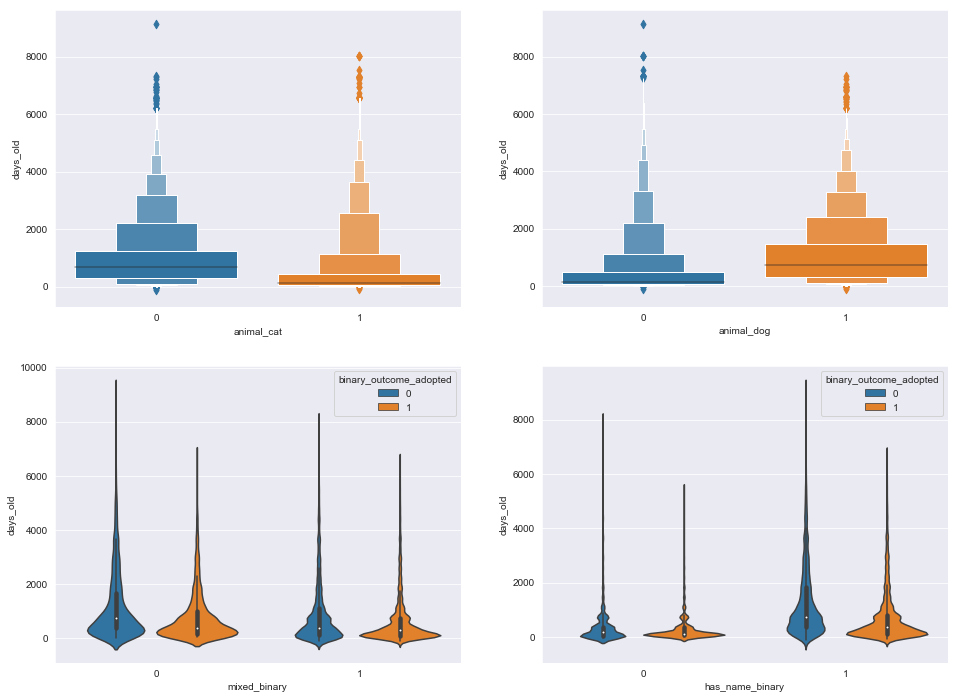

In [30]:
# We can run some visualizations on features against age.
fig, axes = plt.subplots(2, 2, figsize=(16,12))
sns.boxenplot(x='animal_cat', y='days_old', data=df, ax=axes[0, 0])
sns.boxenplot(x='animal_dog', y='days_old', data=df, ax=axes[0, 1])
sns.violinplot(x='mixed_binary', y='days_old', hue='binary_outcome_adopted', data=df, ax=axes[1, 0])
sns.violinplot(x='has_name_binary', y='days_old', hue='binary_outcome_adopted', data=df, ax=axes[1, 1])

### Notes: Cats vs Dogs

The first row houses cats 0 or 1 and dogs 0 or 1. They look eerily inverse. Perhaps some strong correlation exists.

### Correlation confirmed

The correlation is confirmed in the top left of our heatmap.

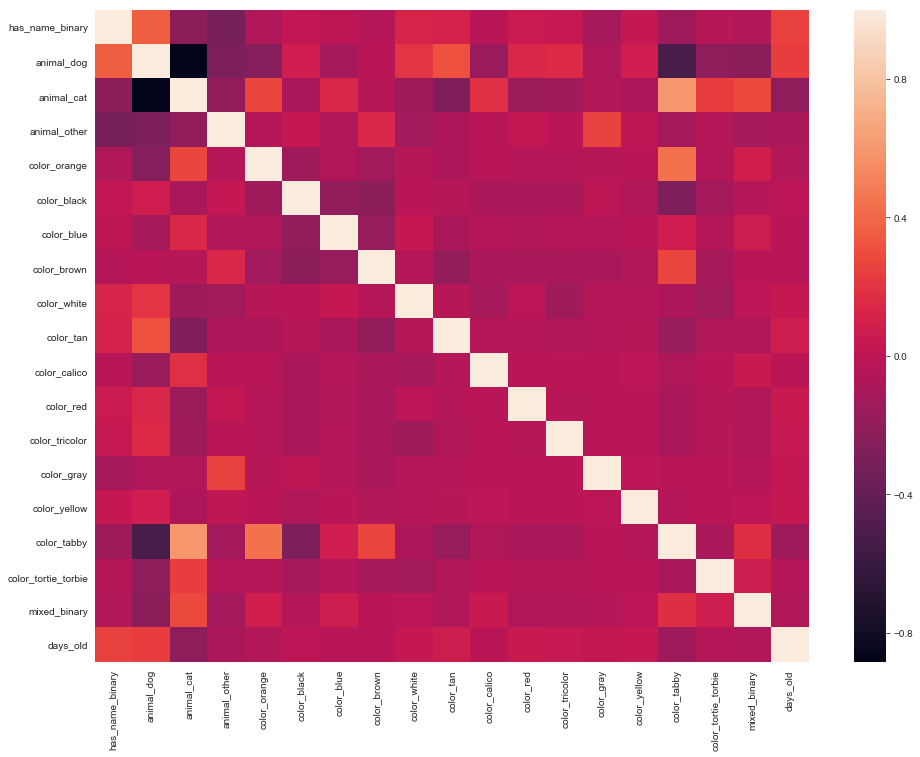

In [31]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(df.iloc[:, 1:].corr())

### Notes: Dog and cat negative correlation

I want to see how the correlation heatmap responds to removing one of these strong negative correlations. Adios, puppers.

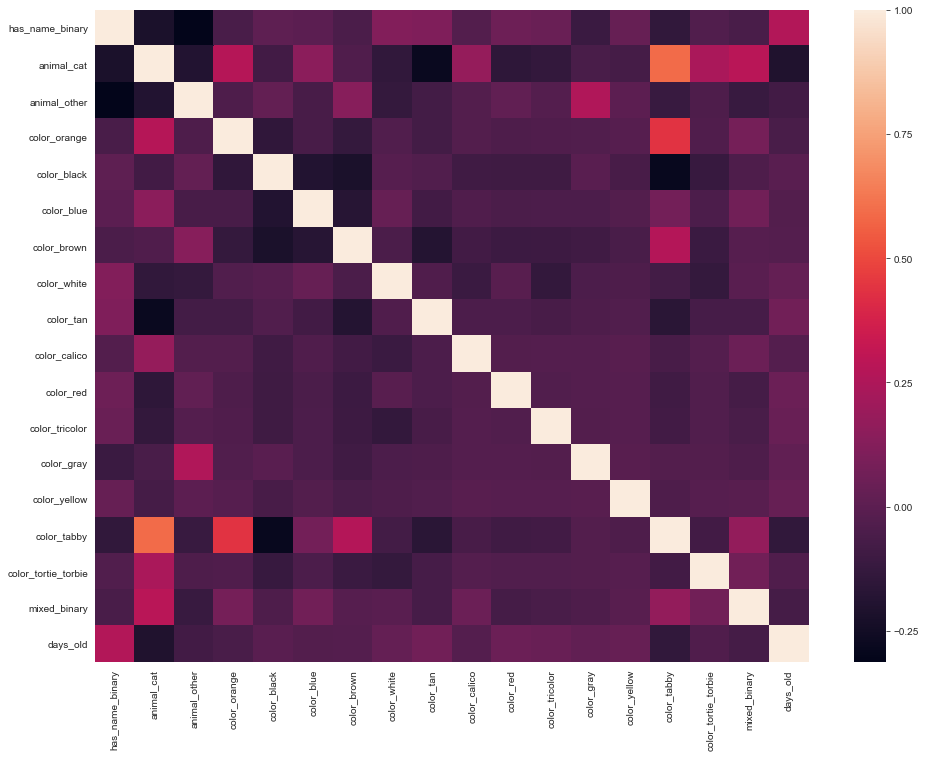

In [32]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(df.drop(['animal_dog', 'binary_outcome_adopted'], 1).corr())

### Notes: Cats, no dogs

This seems to bring in a nice palette of fairly neutral correlations.

# Classification models

### We have a wealth of classification tools to try

We are going to give several a shot.

- Naive Bayes
- Logistic Regression
- Ridge classification
- Lasso classification
- K-Nearest Neighbors classification
- Decision trees
- Random forest classification

Later on, with some idea of what is doing well, we will also try other ensemble methods, including voting.

In [33]:
# Retain a copy of working data
df_with_binary_outcome = df.copy()

# Import necessary libraries for NB, log_reg, ran_for, knn_c, ensembles, and trees
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB # Bernoulli prefers binary inputs!
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

X = df.drop('binary_outcome_adopted', 1)
y = df.binary_outcome_adopted
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

F:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [34]:
%%time
import re # We will need regular expression tricks clean up results and compare them
import time
clf_bnb = BernoulliNB()
clf_gnb = GaussianNB()
clf_log = LogisticRegression(C=1e9) # We need a high alpha value (C) to suppress regularization
clf_rdg = RidgeClassifier(alpha=1000) # Using the same alpha value as LASSO - they are inverses
clf_las = LogisticRegression(penalty='l1', C=0.001) # This is using LASSO for classification
clf_knc = KNeighborsClassifier()
clf_tree = DecisionTreeClassifier() # Basic tree
# Ensemble methods below
clf_rnf = RandomForestClassifier()
clf_ada = AdaBoostClassifier()
clf_gbc = GradientBoostingClassifier()

clf_list = [clf_bnb, clf_gnb, clf_log, clf_rdg, clf_las, clf_knc, clf_tree, clf_rnf, clf_ada, clf_gbc]
pred_dict = {}
coef_dict = {}

for i, clf in enumerate(clf_list):

    name = re.split('\(', str(clf))[0] + '_clf' + str(i)
    print('Model used: {} \nScore: {}\n'.format(name, clf.fit(X_train, y_train).score(X_test, y_test)))
    clf_temp = clf.fit(X_train, y_train)
    pred_dict[name] = clf_temp.predict(X_test)
    try:
        coef_dict[name] = clf.fit(X_train, y_train).coef_
    except:
        pass

Model used: BernoulliNB_clf0 
Score: 0.6813557589080312

Model used: GaussianNB_clf1 
Score: 0.7220489750012781

Model used: LogisticRegression_clf2 
Score: 0.751188589540412

Model used: RidgeClassifier_clf3 
Score: 0.7475589182557129

Model used: LogisticRegression_clf4 
Score: 0.7533868411635397

Model used: KNeighborsClassifier_clf5 
Score: 0.7519554215019683

Model used: DecisionTreeClassifier_clf6 
Score: 0.7487858493942028

Model used: RandomForestClassifier_clf7 
Score: 0.7543581616481775

Model used: AdaBoostClassifier_clf8 
Score: 0.7776187311487143

Model used: GradientBoostingClassifier_clf9 
Score: 0.7919329277644293

Wall time: 18.6 s


### Notes about SVM svc

Support vector machines classifier ran *very* slowly. This is probably in line with the notes about it -

#### Support vector machines run in quadratic time, and they can suffer with data sets including more than a few ten thousand points.

# Models compared

### What do model performances tell us?

In [35]:
print('Coefficients were not so useful, as only -- {} -- models return them to observe. \n\n Model scores:'
      .format(len(coef_dict)))
pred_dict

Coefficients were not so useful, as only -- 4 -- models return them to observe. 

 Model scores:


{'BernoulliNB_clf0': array([0, 1, 0, ..., 1, 0, 0], dtype=int32),
 'GaussianNB_clf1': array([0, 1, 0, ..., 1, 1, 1], dtype=int32),
 'LogisticRegression_clf2': array([0, 1, 0, ..., 1, 0, 1], dtype=int32),
 'RidgeClassifier_clf3': array([0, 1, 0, ..., 1, 0, 1], dtype=int32),
 'LogisticRegression_clf4': array([0, 1, 0, ..., 1, 0, 1], dtype=int32),
 'KNeighborsClassifier_clf5': array([1, 1, 0, ..., 1, 1, 1], dtype=int32),
 'DecisionTreeClassifier_clf6': array([0, 1, 0, ..., 1, 0, 1], dtype=int32),
 'RandomForestClassifier_clf7': array([0, 1, 0, ..., 1, 0, 1], dtype=int32),
 'AdaBoostClassifier_clf8': array([0, 1, 0, ..., 1, 0, 1], dtype=int32),
 'GradientBoostingClassifier_clf9': array([0, 1, 0, ..., 1, 0, 1], dtype=int32)}

### Outcomes

The outcomes look consistent. Let's graph the confusion matrix results.

### Confusion matrices compared:

Below, we have the outputs of confusion matrices for each model's performance.

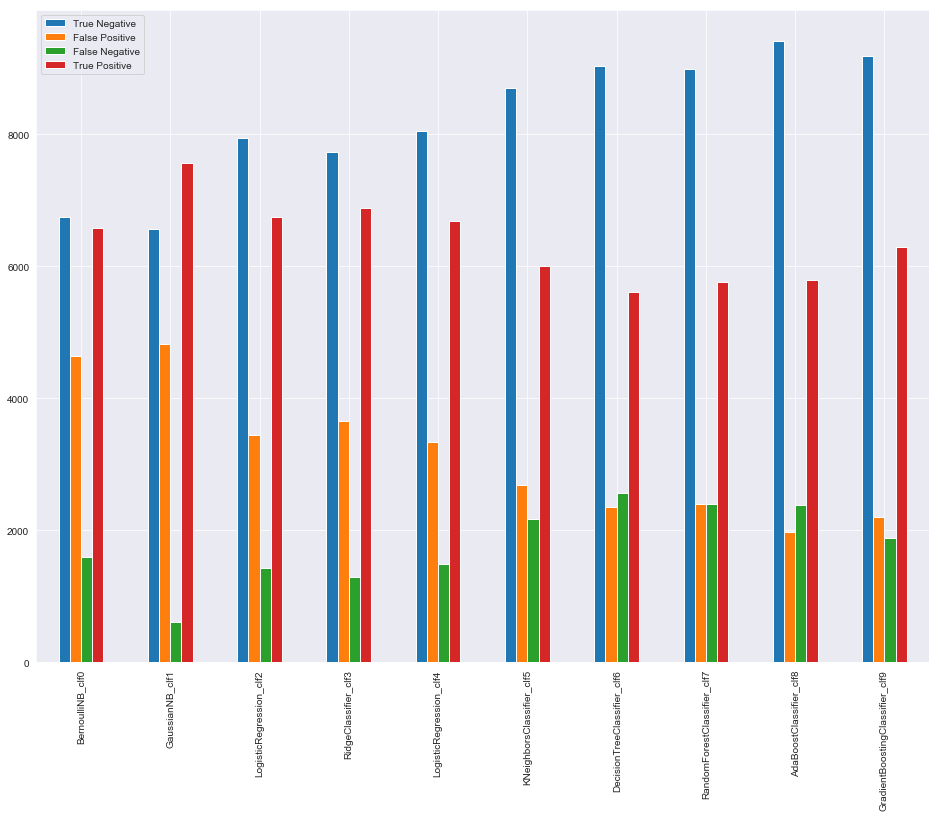

In [36]:
df_con = pd.DataFrame(np.array([(confusion_matrix(y_test, pred_dict[key]).ravel()) for key in pred_dict.keys()]),
             index=pred_dict.keys(), columns=['True Negative', 'False Positive', 'False Negative', 'True Positive'])

df_con.plot(kind='bar', figsize=(16,12))

### Notes: Confusion matrices comparisons

Ultimately, I think building an ensemble of well-performing models will make easy work of the predictions.

1. GaussianNB
    - This model is doing a *great* job of avoiding false negatives and identifying true positives.


2. DecisionTree
    - This model is doing surprisingly well as a single tree - particularly in the true negative category.


3. LASSO classification
    - It might be advisable to use Lasso for voting ensembles, as it is eliminating noise and offers a very different approach. Its numbers aren't too shabby either.
    
#### GradientBoosting performed quite well out of the box. Since this is an ensemble approach, we'll skip over it for now.

# GridSearch to optimize models

We will begin with optimizing the models that are doing well already - as mentioned above: GaussianNB, DecisionTree, and LASSO.

In [37]:
clf_gnb = GaussianNB()
clf_tree = DecisionTreeClassifier()
clf_las = LogisticRegression()

gnb_params = {'var_smoothing': [1e-10, 1e-9, 1e-8]} # This only works with specified priors
tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, None]}
las_params = {'penalty': ['l1'], 'C': [1, 1e-1, 1e-2, 1e-3], 'solver': ['liblinear', 'saga']}

#GridSearchCV(clf_gnb, gnb_params, cv=5).fit(X_train, y_train)
grid_tree = GridSearchCV(clf_tree, tree_params, cv=5).fit(X_train, y_train)
grid_las = GridSearchCV(clf_las, las_params, cv=5).fit(X_train, y_train)

F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
F:\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [38]:
print('Decision tree results:')
display(grid_tree.best_params_)
display(grid_tree.best_score_)
print('\nLASSO results:')
display(grid_las.best_params_)
display(grid_las.best_score_)

Decision tree results:


{'criterion': 'gini', 'max_depth': 4}

0.7644252070481579


LASSO results:


{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}

0.752274973586449

### Notes: Tuned hyperparameters

We aren't seeing significant changes here - it's back to the drawing board. We can beat the GradientBoostingClassifier an AdaBoostClassifier somehow. *Also note we can not tune Naive Bayes in this context - no priors exist.*

# Feature tuning: Two more ideas

### 1. Colors: other

Let's introduce the colors_other into the model; we lost some information discarding that.

### 2. Multiclass

Perhaps the grouping of adopted versus all was a bad choice. After all, returned to owner and euthanized could be quite different in their characteristics.

In [39]:
# 1. Introducing other colors back into the mix.
df['color_others'] = 0
df.loc[color_others.index, 'color_others'] = 1
df.color_others.value_counts()

0    74925
1     3318
Name: color_others, dtype: int64

In [40]:
# 2. We are going to replace outcome_binary with a outcome multiclass.
outcome_other = df[(df2.outcome_type == 'Euthanasia') | (df2.outcome_type == 'Died') | (df2.outcome_type == 'Disposal')
                 | (df2.outcome_type == 'Rto-Adopt') | (df2.outcome_type == 'Missing') | (df2.outcome_type == 'Relocate')].index

df['outcome_type'] = df2.loc[df.index, 'outcome_type']
df.loc[outcome_other, 'outcome_type'] = 'Other'
outcome_ints = pd.factorize(df.outcome_type)
df['outcome_type_int'] = outcome_ints[0]
df.drop(['outcome_type', 'binary_outcome_adopted'], 1, inplace=True)
df.outcome_type_int.value_counts()

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


1    33112
0    23499
3    14353
2     7279
Name: outcome_type_int, dtype: int64

# Cleaned up

### Our data set now has a multi class outcome and more color options included.

In [41]:
from sklearn.metrics import f1_score

X = df.drop('outcome_type_int', 1)
y = df.outcome_type_int

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

clf_gnb = GaussianNB()
print('Gaussian')
display(clf_gnb.fit(X_train, y_train).score(X_test, y_test))

clf_bnb = BernoulliNB()
print('Bernoulli')
display(clf_bnb.fit(X_train, y_train).score(X_test, y_test))

clf_tree = DecisionTreeClassifier(class_weight='balanced')
print('Decision Tree')
display(clf_tree.fit(X_train, y_train).score(X_test, y_test))

clf_rfc = RandomForestClassifier(class_weight='balanced')
print('Random Forest')
display(clf_rfc.fit(X_train, y_train).score(X_test, y_test))

clf_rdg = RidgeClassifier()
print('Ridge')
display(clf_rdg.fit(X_train, y_train).score(X_test, y_test))

clf_knc = KNeighborsClassifier()
print('K Neighbors')
display(clf_knc.fit(X_train, y_train).score(X_test, y_test))

clf_l1 = LogisticRegression(penalty='l1', C=0.001, class_weight='balanced')
print('LASSO')
display(clf.fit(X_train, y_train).score(X_test, y_test))

Gaussian


0.505240018403967

Bernoulli


0.5610653852052554

Decision Tree


0.6133633249833853

Random Forest


0.6290066969991309

Ridge


0.638362046930116

K Neighbors


0.6540054189458616

LASSO


0.7078370226471039

# Strongest of the bunch

### Random forest, K Neighbors, and LASSO are doing quite well

Let's remember that in a four-way classification problem, scores above 25 percent are doing better than merely guessing. So, despite lower scores here, the models aren't bad.

LASSO is performing *exceptionally* well, so this is probably the model to choose, but let's tune what we can with the three strongest.

In [42]:
params_rfc = {'n_estimators': [10, 50, 100], 'class_weight': ['balanced', None]}
params_knc = {'weights': ['uniform', 'distance'], 'n_neighbors': [2, 3, 4, 5]}
params_l1 = {'C': [1e-1, 1e-2, 1e-3, 5e-3, 1e-4], 'class_weight': ['balanced', None]}

grid_rfc = GridSearchCV(clf_rfc, params_rfc, cv=5).fit(X_train, y_train)
grid_knc = GridSearchCV(clf_knc, params_knc, cv=5).fit(X_train, y_train)
grid_l1 = GridSearchCV(clf_l1, params_l1, cv=5).fit(X_train, y_train)

print('Random forest classifier')
display(grid_rfc.best_params_)
display(grid_rfc.best_score_)
print('\nK neighbors classifier')
display(grid_knc.best_params_)
display(grid_knc.best_score_)
print('\nLASSO classification')
display(grid_l1.best_params_)
display(grid_l1.best_score_)

Random forest classifier


{'class_weight': None, 'n_estimators': 50}

0.627892709859923


K neighbors classifier


{'n_neighbors': 5, 'weights': 'uniform'}

0.6499096826965679


LASSO classification


{'C': 0.1, 'class_weight': 'balanced'}

0.6551923928973109

In [43]:
y_rfc = RandomForestClassifier(n_estimators=50, class_weight=None).fit(X_train, y_train).predict(X_test)
y_knc = KNeighborsClassifier(n_neighbors=5, weights='uniform').fit(X_train, y_train).predict(X_test)
y_l1 = LogisticRegression(C=5e-3, class_weight='balanced').fit(X_train, y_train).predict(X_test)

display(f1_score(y_test, y_rfc, average='weighted'))
display(f1_score(y_test, y_knc, average='weighted'))
display(f1_score(y_test, y_l1, average='weighted'))

0.6391331690735352

0.6485366251902928

0.6448840527955034

# Interpreting f1 scores

### Multiclass scores

F1 scores are effective at telling us the power of accuracy and recall across the model. 

$$f = 2 * (p * r) / (p + r)$$

Where f represents the f1 score, p the precision, and r the recall.

In the case of the multiclass labels, we have to use an averaging method to calculate the score. F1 scores will be calculated for each class, and we can find a better metric of the holistic performance. The confusion matrix below shows the values:

In [44]:
confusion_matrix(y_test, y_knc)

array([[3522, 1759,  156,  412],
       [1035, 6534,   34,  633],
       [ 434,  261,  973,  161],
       [ 536, 1283,   64, 1764]], dtype=int64)

### K Nearest Neighbors

From these results, it looks like the KNeighborsClassifier performed better on average; it maintained across different metrics. Given these figures, it is the single model I would select based on this performance. (Looks like I was wrong about LASSO.)

However, we have not revisited the ensemble methods that did so well on binary classification. Let's see how the GradientBoostingClassifier performs on our multiclass problem.

In [45]:
clf_gbc = GradientBoostingClassifier()
clf_gbc.fit(X_train, y_train).score(X_test, y_test)

0.7078370226471039

In [46]:
y_gbc = clf_gbc.fit(X_train, y_train).predict(X_test)
f1_score(y_test, y_gbc, average='weighted')

0.7010530536066961

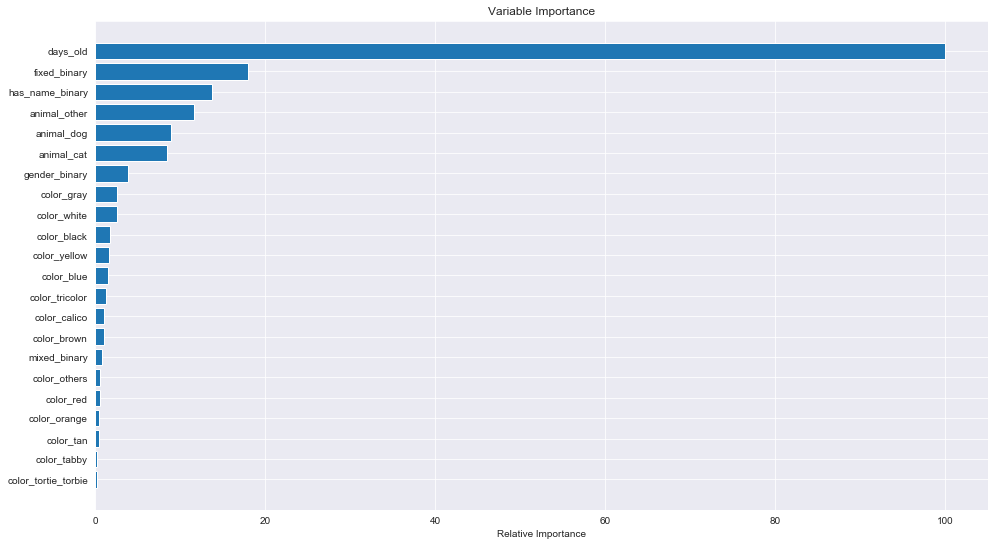

In [47]:
# Slightly but hardly modified feature graphing - taken from Thinkful supervised learning
feature_importance = clf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplots(figsize=(16, 9))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Notes: Feature importances - Gradient Boosting

As it is not a complete black box, we are able to compare the predictive and explanatory power of features. Above we can see that the featured 'days_old' feature turned out to be strongest, by a landslide. Others we suspected to be important, such as 'fixed_binary', came in second. In third, we can see that animals without names were consistently connected in outcome groups. This is interesting indeed.

# Ensembles still stronger

### K-Neighbors

The K-Neighbors classifier performed at about 0.65 for the multi-class classification problem. This seems to be pretty great in comparison to the ensemble score, which is only 0.05 or so stronger.

### Gradient Boosting Classifier

This ensemble classifier certainly beat the single model, which is to be expected - its performance sitting right around 0.70. There might exist a theroetical performance ceiling somewhere along the way. At some point, improving scores without overfitting won't happen.

# Explanatory versus predictive powers

### Gradient boosting (semi-black box) or KNC with explanation?

Both models are doing quite well at predictions, with the ensemble taking the lead. It has the upper hand in pure prediction, but what does it tell us? What does it help to explain? It is lacking in this department, and doesn't give us the keys to know tons about our information. We can deduce a little about feature importances by pulling out the feature_importances_ method from the model - but this as far as we can see. On the other hand, K-Neighbors will give us a glimpse of what is happening in the background.

With these two models as the finalists, we now have one reasoning the outcome and another handling pure predictions well.